## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs/gdxray")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
#SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")
GDXRAY_MODEL_PATH = "C:/Users/Noelia/mask_rcnn_gdxray_0159.h5"

C:\Users\Noelia\Anaconda3\envs\defect-detection\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
#import coco
#config = coco.CocoConfig()
#COCO_DIR = "path to COCO dataset"  # TODO: enter value here

# GDXray Dataset
import gdxray
config = gdxray.TrainConfig()
DATA_DIR = os.path.expanduser("~/data/gdxray")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[192 192]
 [ 96  96]
 [ 48  48]
 [ 24  24]
 [ 12  12]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  768
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (128, 128)
NAME                           gdxray
NUM_CLASSES                    3
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING      

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Build validation dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset = coco.CocoDataset()
    dataset.load_coco(DATA_DIR, "minival")
elif config.NAME == "gdxray":
    dataset = gdxray.XrayDataset()
    dataset.load_gdxray(DATA_DIR, "train", "Castings")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Adding image: Castings/C0001/C0001_0001.png
Adding image: Castings/C0001/C0001_0002.png
Adding image: Castings/C0001/C0001_0003.png
Adding image: Castings/C0001/C0001_0004.png
Adding image: Castings/C0001/C0001_0005.png
Adding image: Castings/C0001/C0001_0006.png
Adding image: Castings/C0001/C0001_0009.png
Adding image: Castings/C0001/C0001_0010.png
Adding image: Castings/C0001/C0001_0011.png
Adding image: Castings/C0001/C0001_0012.png
Adding image: Castings/C0001/C0001_0013.png
Adding image: Castings/C0001/C0001_0017.png
Adding image: Castings/C0001/C0001_0018.png
Adding image: Castings/C0001/C0001_0019.png
Adding image: Castings/C0001/C0001_0022.png
Adding image: Castings/C0001/C0001_0023.png
Adding image: Castings/C0001/C0001_0024.png
Adding image: Castings/C0001/C0001_0025.png
Adding image: Castings/C0001/C0001_0026.png
Adding image: Castings/C0001/C0001_0027.png
Adding image: Castings/C0001/C0001_0028.png
Adding image: Castings/C0001/C0001_0031.png
Adding image: Castings/C0001/C00

Adding image: Castings/C0021/C0021_0021.png
Adding image: Castings/C0021/C0021_0022.png
Adding image: Castings/C0021/C0021_0025.png
Adding image: Castings/C0021/C0021_0026.png
Adding image: Castings/C0021/C0021_0027.png
Adding image: Castings/C0021/C0021_0029.png
Adding image: Castings/C0021/C0021_0031.png
Adding image: Castings/C0021/C0021_0032.png
Adding image: Castings/C0021/C0021_0033.png
Adding image: Castings/C0021/C0021_0034.png
Adding image: Castings/C0021/C0021_0035.png
Adding image: Castings/C0021/C0021_0036.png
Adding image: Castings/C0021/C0021_0037.png
Adding image: Castings/C0024/C0024_0017.png
Adding image: Castings/C0024/C0024_0018.png
Adding image: Castings/C0024/C0024_0019.png
Adding image: Castings/C0024/C0024_0020.png
Adding image: Castings/C0024/C0024_0021.png
Adding image: Castings/C0024/C0024_0022.png
Adding image: Castings/C0024/C0024_0023.png
Adding image: Castings/C0024/C0024_0024.png
Adding image: Castings/C0024/C0024_0025.png
Adding image: Castings/C0024/C00

Adding image: Castings/C0036/C0036_0026.png
Adding image: Castings/C0036/C0036_0027.png
Adding image: Castings/C0036/C0036_0028.png
Adding image: Castings/C0036/C0036_0029.png
Adding image: Castings/C0036/C0036_0031.png
Adding image: Castings/C0036/C0036_0032.png
Adding image: Castings/C0036/C0036_0033.png
Adding image: Castings/C0036/C0036_0035.png
Adding image: Castings/C0038/C0038_0009.png
Adding image: Castings/C0038/C0038_0010.png
Adding image: Castings/C0038/C0038_0011.png
Adding image: Castings/C0038/C0038_0012.png
Adding image: Castings/C0038/C0038_0014.png
Adding image: Castings/C0038/C0038_0015.png
Adding image: Castings/C0038/C0038_0016.png
Adding image: Castings/C0038/C0038_0017.png
Adding image: Castings/C0038/C0038_0018.png
Adding image: Castings/C0038/C0038_0019.png
Adding image: Castings/C0038/C0038_0020.png
Adding image: Castings/C0038/C0038_0021.png
Adding image: Castings/C0039/C0039_0013.png
Adding image: Castings/C0039/C0039_0016.png
Adding image: Castings/C0039/C00

Adding image: Castings/C0051/C0051_0059.png
Adding image: Castings/C0051/C0051_0061.png
Adding image: Castings/C0051/C0051_0064.png
Adding image: Castings/C0051/C0051_0066.png
Adding image: Castings/C0051/C0051_0067.png
Adding image: Castings/C0051/C0051_0072.png
Adding image: Castings/C0051/C0051_0073.png
Adding image: Castings/C0051/C0051_0074.png
Adding image: Castings/C0051/C0051_0075.png
Adding image: Castings/C0051/C0051_0076.png
Adding image: Castings/C0054/C0054_0001.png
Adding image: Castings/C0054/C0054_0002.png
Adding image: Castings/C0054/C0054_0003.png
Adding image: Castings/C0054/C0054_0004.png
Adding image: Castings/C0054/C0054_0005.png
Adding image: Castings/C0054/C0054_0006.png
Adding image: Castings/C0054/C0054_0007.png
Adding image: Castings/C0054/C0054_0010.png
Adding image: Castings/C0054/C0054_0011.png
Adding image: Castings/C0054/C0054_0012.png
Adding image: Castings/C0054/C0054_0013.png
Adding image: Castings/C0054/C0054_0014.png
Adding image: Castings/C0054/C00

## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

# Set weights file path
if config.NAME == "shapes":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
elif config.NAME == "gdxray":
    weights_path = GDXRAY_MODEL_PATH
    
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.
Loading weights  C:/Users/Noelia/mask_rcnn_gdxray_0159.h5








## Run Detection

image ID: gdxray.Castings/C0001/C0001_0001.png (0) None
Processing 1 images
image                    shape: (768, 768, 3)         min:    0.00000  max:  207.00000
molded_images            shape: (1, 768, 768, 3)      min: -123.70000  max:  103.10000
image_metas              shape: (1, 11)               min:    0.00000  max:  768.00000


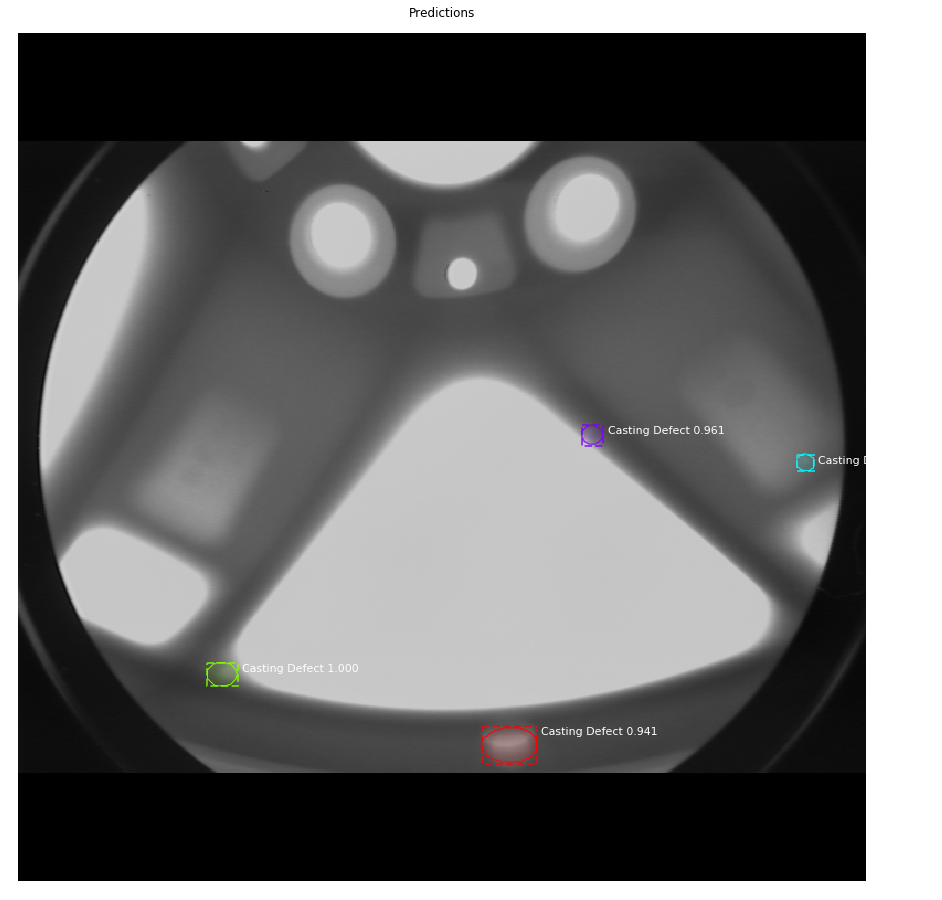

gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (1, 4)                min:  171.00000  max:  591.00000
gt_mask                  shape: (768, 768, 1)         min:    0.00000  max:    1.00000


In [8]:
image_id = random.choice(dataset.image_ids)
image_id = 0

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

### Precision-Recall

gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (2, 4)                min:  103.00000  max:  624.00000
gt_mask                  shape: (768, 768, 2)         min:    0.00000  max:    1.00000


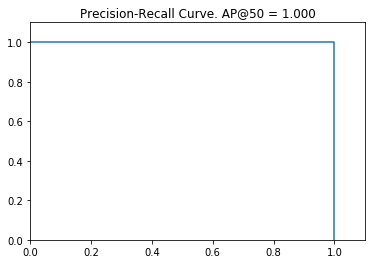

In [9]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

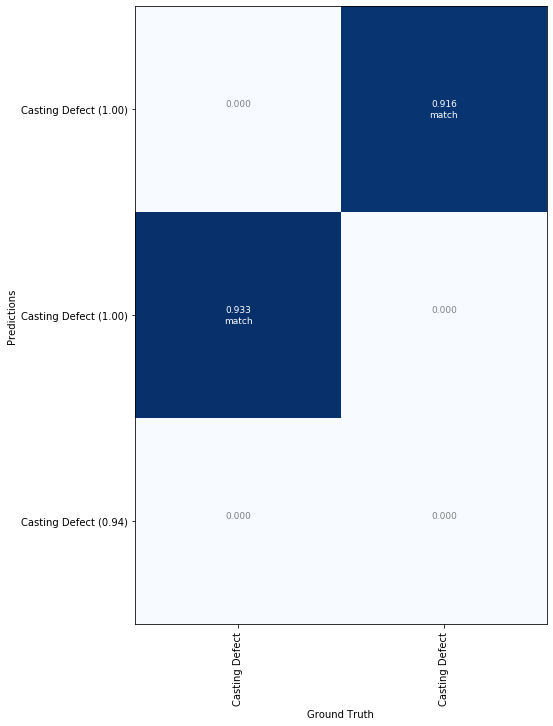

In [10]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [11]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

C:\Users\Noelia/data/gdxray\Castings/C0008/C0008_0018.png
C:\Users\Noelia/data/gdxray\Castings/C0034/C0034_0032.png
C:\Users\Noelia/data/gdxray\Castings/C0031/C0031_0011.png
C:\Users\Noelia/data/gdxray\Castings/C0035/C0035_0015.png
C:\Users\Noelia/data/gdxray\Castings/C0030/C0030_0017.png
C:\Users\Noelia/data/gdxray\Castings/C0040/C0040_0036.png
C:\Users\Noelia/data/gdxray\Castings/C0055/C0055_0019.png
C:\Users\Noelia/data/gdxray\Castings/C0051/C0051_0046.png
C:\Users\Noelia/data/gdxray\Castings/C0041/C0041_0006.png
C:\Users\Noelia/data/gdxray\Castings/C0043/C0043_0011.png
mAP @ IoU=50:  1.0


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [12]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (147312,)             min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (256, 4)              min:   -2.77106  max:    1.56250
positive_anchors         shape: (2, 4)                min:   89.37258  max:  624.00000
negative_anchors         shape: (254, 4)              min:  -90.50967  max:  782.62742
neutral anchors          shape: (147056, 4)           min: -181.01934  max:  885.01934
refined_anchors          shape: (2, 4)                min:  103.00000  max:  624.00000


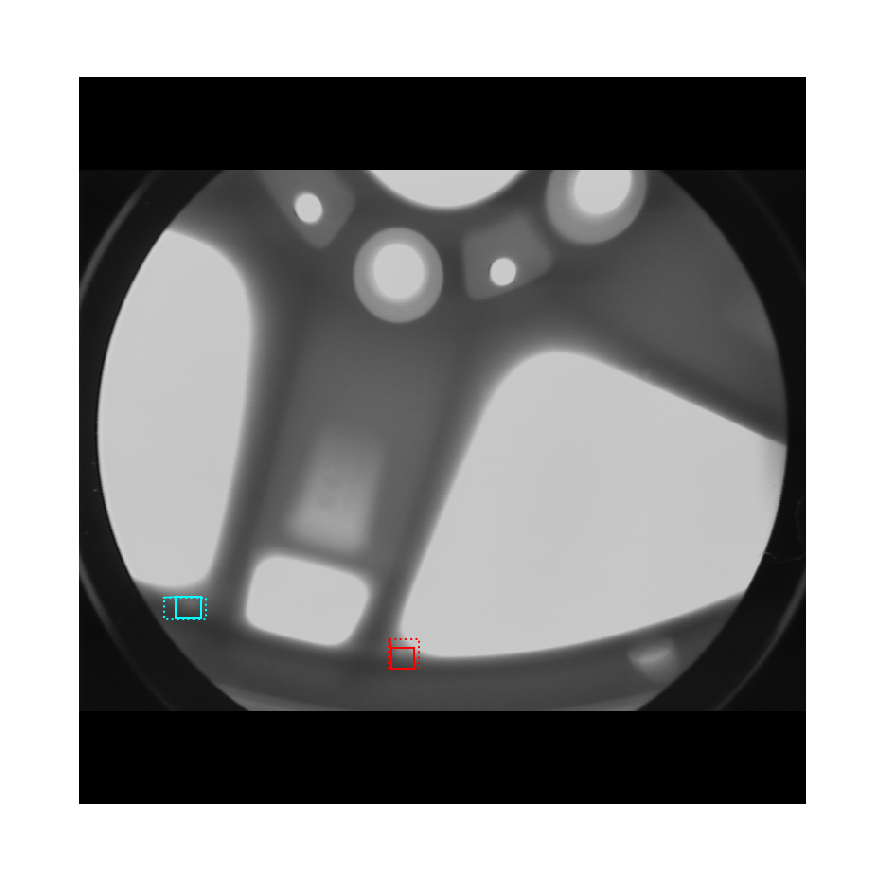

In [13]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

In [ ]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

In [ ]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

In [ ]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
proposals = proposals + [100,0,100,0]
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [ ]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [14]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

odict_values([<tf.Tensor 'ROI/packed_2:0' shape=(1, ?, 4) dtype=float32>, <tf.Tensor 'mrcnn_class/Reshape_1:0' shape=(?, 1000, 3) dtype=float32>, <tf.Tensor 'mrcnn_bbox/Reshape:0' shape=(?, 1000, 3, 4) dtype=float32>, <tf.Tensor 'mrcnn_mask/Reshape_1:0' shape=(?, 100, 28, 28, 3) dtype=float32>, <tf.Tensor 'mrcnn_detection/Reshape_1:0' shape=(1, 100, 6) dtype=float32>])
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 1000, 3)          min:    0.00000  max:    1.00000
deltas                   shape: (1, 1000, 3, 4)       min:   -4.94637  max:    4.13059
masks                    shape: (1, 100, 28, 28, 3)   min:    0.00000  max:    1.00000
detections               shape: (1, 100, 6)           min:    0.00000  max:  624.00000


3 detections: ['Casting Defect' 'Casting Defect' 'Casting Defect']


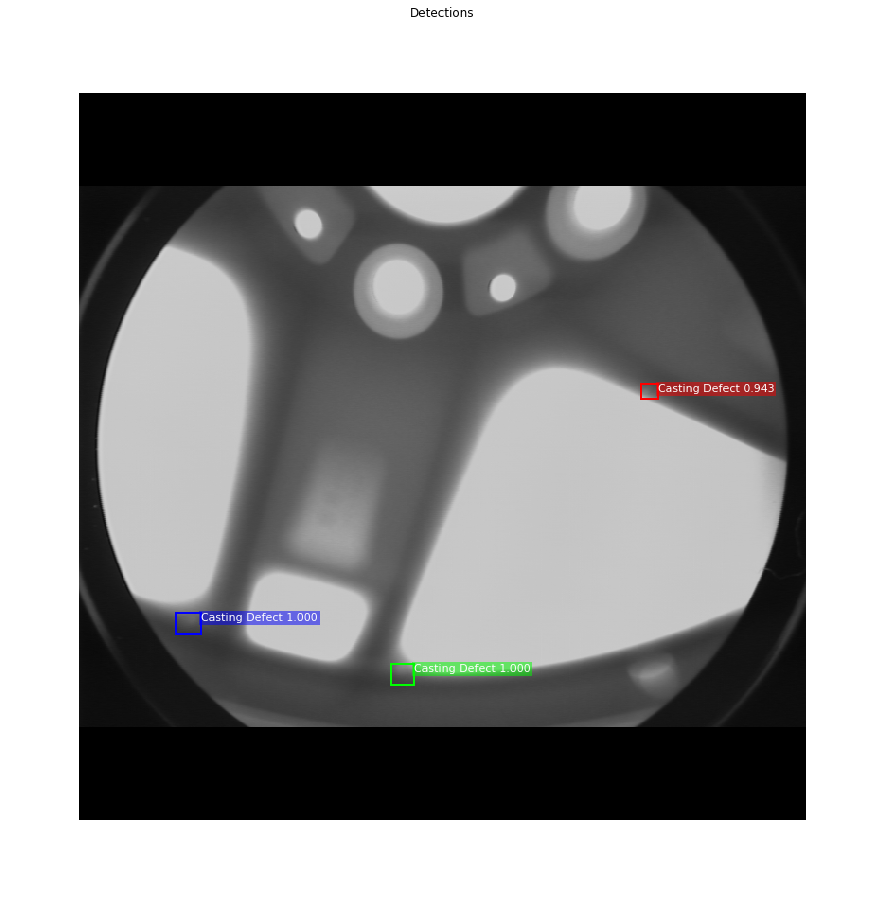

In [15]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=detections[:, :4],
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [16]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
7 Positive ROIs
[('BG', 993), ('Casting Defect', 7)]


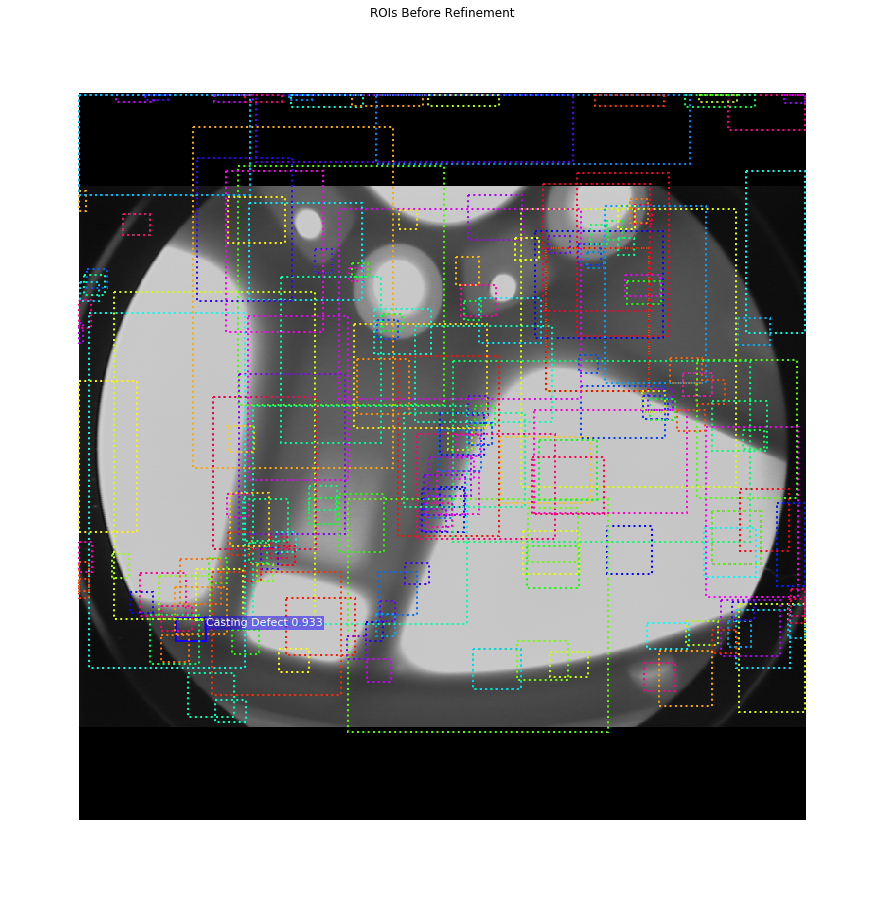

In [17]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

In [18]:
from importlib import reload
reload(visualize)

<module 'visualize' from 'C:\\Users\\Noelia\\Universidad\\TFG\\Artículos\\Artículo 2\\metal-defect-detection-master\\visualize.py'>

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -2.64418  max:    3.65099
refined_proposals        shape: (1000, 4)             min:    0.00000  max:  915.00000


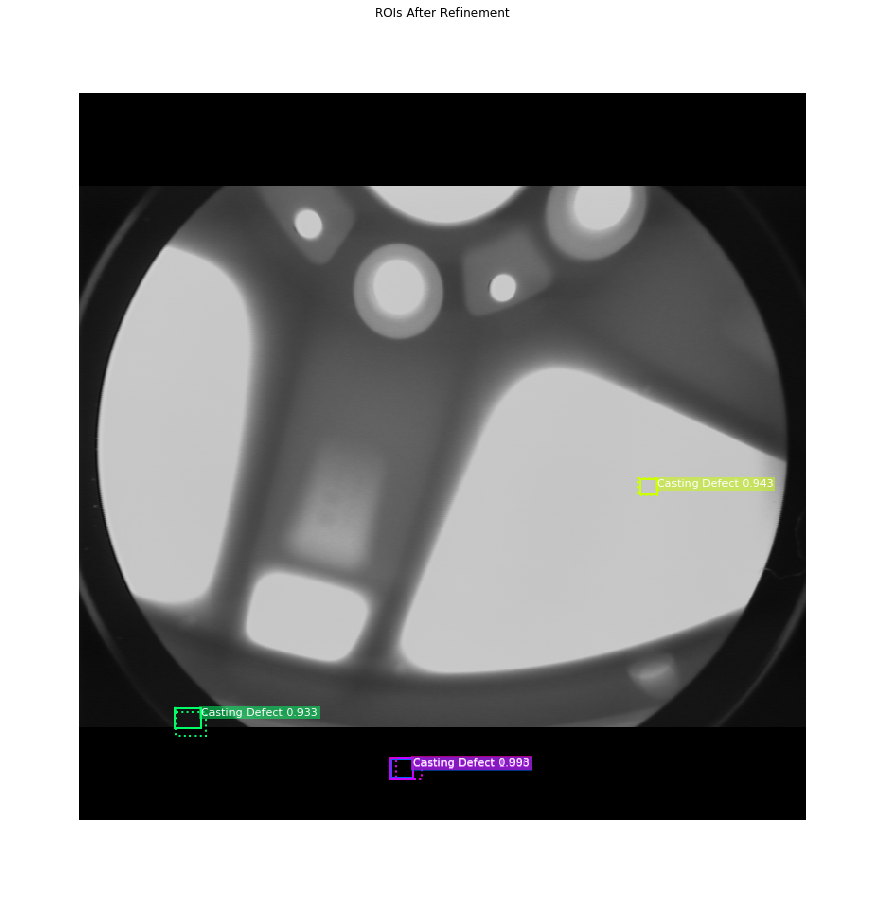

In [19]:
#from importlib import reload
#reload(visualize)

# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

proposals = proposals + [100,0,100,0]

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)



# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [20]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 7 detections:
[  0   1   2  11  21 111 356]


In [21]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.7 confidence. Keep 6:
[  0   1   2  11 111 356]


#### Per-Class Non-Max Suppression

In [22]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

Casting Defect        : [  0   1   2  11 111 356] -> [1 0 2]

Kept after per-class NMS: 3
[0 1 2]


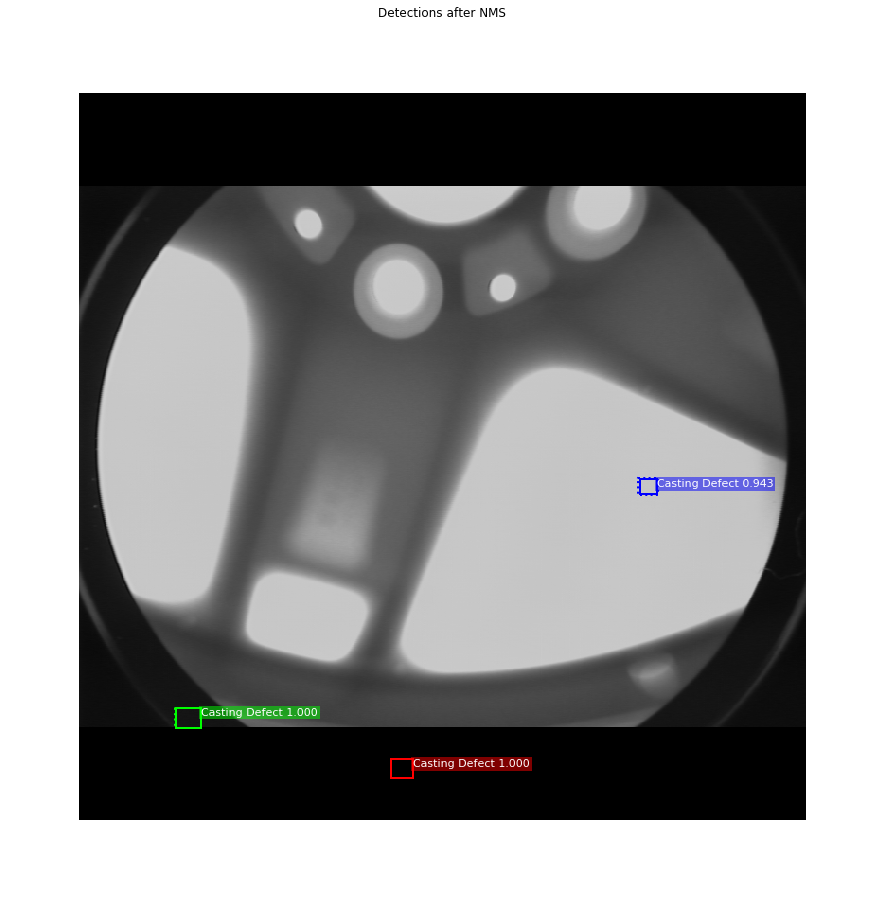

In [23]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

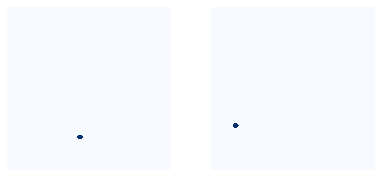

In [24]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [25]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

odict_values([<tf.Tensor 'mrcnn_detection/Reshape_1:0' shape=(1, 100, 6) dtype=float32>, <tf.Tensor 'mrcnn_mask/Reshape_1:0' shape=(?, 100, 28, 28, 3) dtype=float32>])
detections               shape: (1, 100, 6)           min:    0.00000  max:  624.00000
masks                    shape: (1, 100, 28, 28, 3)   min:    0.00000  max:    1.00000
3 detections: ['Casting Defect' 'Casting Defect' 'Casting Defect']


In [26]:
# Masks
det_boxes = mrcnn["detections"][0, :, :4].astype(np.int32)
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (3, 28, 28)           min:    0.00000  max:    1.00000
det_masks                shape: (3, 768, 768)         min:    0.00000  max:    1.00000


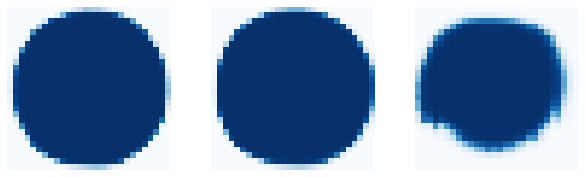

In [27]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

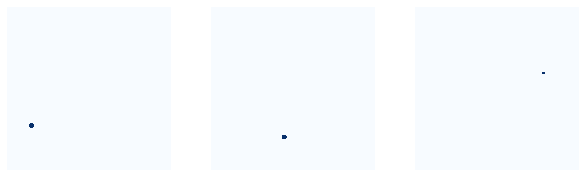

In [28]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [29]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

odict_values([<tf.Tensor 'input_image:0' shape=(?, 768, 768, 3) dtype=float32>, <tf.Tensor 'res4w_out/Relu:0' shape=(?, 48, 48, 1024) dtype=float32>, <tf.Tensor 'rpn_bbox/concat:0' shape=(?, ?, 4) dtype=float32>, <tf.Tensor 'ROI/packed_2:0' shape=(1, ?, 4) dtype=float32>])
input_image              shape: (1, 768, 768, 3)      min: -123.70000  max:  103.10000
res4w_out                shape: (1, 48, 48, 1024)     min:    0.00000  max:   58.66101
rpn_bbox                 shape: (1, 147312, 4)        min:   -5.84197  max:   11.93149
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


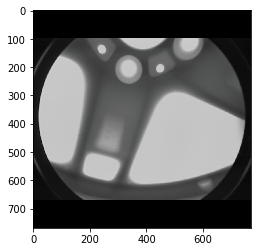

In [30]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

odict_keys(['input_image', 'res4w_out', 'rpn_bbox', 'roi'])


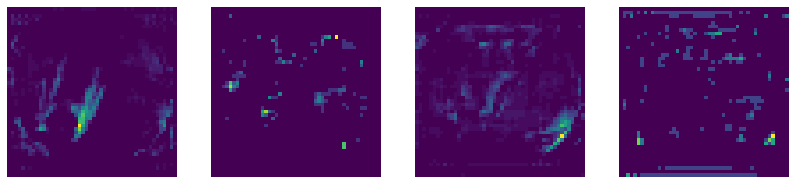

In [31]:
# Backbone feature map
print(activations.keys())
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

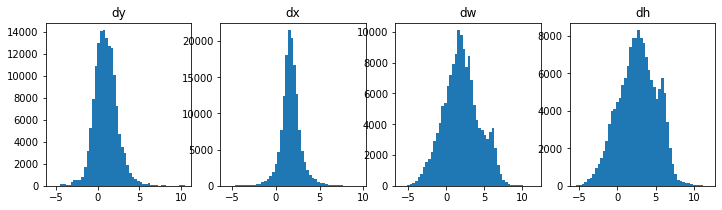

In [32]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

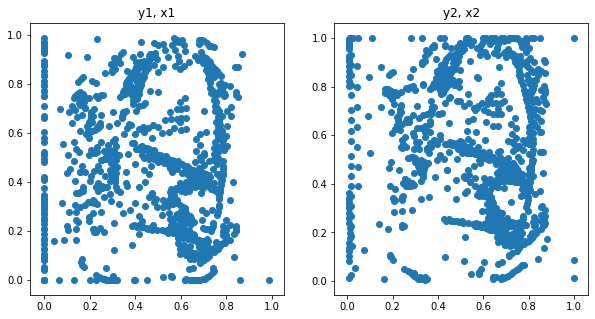

In [33]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()